In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import time

# Paths and stuff
import os
import sys

sys.path.append('/home/shreyas/pySICOPOLIS/src')
from pySICOPOLIS import *

In [2]:
# ds_prior_X = xr.open_dataset("/scratch2/shreyas/optim_SVC_3point5/prior_X.nc")
# np.max(1/ds_prior_X["xx_c_slide_initd"].data) / np.min(1/ds_prior_X["xx_c_slide_initd"].data), \
# np.max(1/ds_prior_X["xx_q_geod"].data) / np.min(1/ds_prior_X["xx_q_geod"].data), \
# np.min(1/ds_prior_X["xx_c_slide_initd"].data), np.min(1/ds_prior_X["xx_q_geod"].data)

In [3]:
# ds_prior_X = xr.open_dataset("/scratch2/shreyas/tuneCS_mini/prior_X.nc")
# np.max(1/ds_prior_X["xx_c_slide_initd"].data) / np.min(1/ds_prior_X["xx_c_slide_initd"].data), \
# np.max(1/ds_prior_X["xx_q_geod"].data) / np.min(1/ds_prior_X["xx_q_geod"].data), \
# np.min(1/ds_prior_X["xx_c_slide_initd"].data), np.min(1/ds_prior_X["xx_q_geod"].data)

In [4]:
ds_grl40_bm5_paleo17a_CT4_BH0_m21ka_pkp_init = xr.open_dataset('/home/shreyas/update_to_develop_sicopolis/sicopolis_spinups/sico_out/grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka/grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka0005.nc')
surfvel_data_40kms = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/surfvel_data_40kms.nc")
vx_uncert_data = surfvel_data_40kms["vx_uncert"].data
vy_uncert_data = surfvel_data_40kms["vy_uncert"].data

In [5]:
sicopolis_dir = '/home/shreyas/update_to_develop_sicopolis/sicopolis_tuneCS_mini'
simulation = 'grl40_bm5_paleo17a_nudged_CT4_BH0_SVC_m21ka_pkp'
dict_sico_out_folder_prefixes = {"nodiff": "N",
                                 "tlm": "FORWARD",
                                 "adj": "ADJOINT",
                                 "tlm_action": "FORWARDHESSACTION",
                                 "adj_action": "ADJHESSACTION"}
dict_ad_exec_cmds_suffixes = {"nodiff": "nodiff",
                              "tlm": "forward",
                              "adj": "adjoint",
                              "tlm_action": "forwardhessaction",
                              "adj_action": "adjointhessaction"}
dict_ad_log_file_suffixes = {"nodiff": "nodiff",
                             "tlm": "tlm",
                             "adj": "adj",
                             "tlm_action": "tlm_hessaction",
                             "adj_action": "adj_hessaction"}
dict_ad_nc_suffixes = {"nodiff": "nodiff",
                       "tlm": "tlm",
                       "adj": "adj",
                       "tlm_action": "tlm_hessaction",
                       "adj_action": "adj_hessaction"}

KCMAX = 80
exp_sigma_level = dataCleaner.exp_sigma_level(zeta = np.arange(0,1+1./KCMAX,1./KCMAX),
                                              exponent = 2.0)
KRMAX = 40
zeta_r = np.arange(0.,1. + 1.0/KRMAX, 1.0/KRMAX)
xModel40       = np.arange(-72.,97.,4.0)*10
yModel40       = np.arange(-345.,-56.,4.0)*10
time_ad = np.arange(6, dtype=float)
IMAX = xModel40.shape[0]-1
JMAX = yModel40.shape[0]-1
NTDAMAX = time_ad.shape[0]-1

log_c_slide_init = np.log10(0.85)*np.ones((JMAX+1, IMAX+1))
data = ds_grl40_bm5_paleo17a_CT4_BH0_m21ka_pkp_init['q_geo'].data
log_q_geo = np.where(data > 0, np.log10(data), -10)
log_p_weert = np.log10(3.0)
log_q_weert = np.log10(2.0)
log_enh_fact_da_dummy2d_scalar = np.log10(3.0)
log_enh_intg_da_dummy2d_scalar = np.log10(1.0)
log_n_glen_da_dummy2d_scalar = np.log10(3.0)

# Ensure the sequence in these arrays is the same as defined in ad_specs.h
dict_og_params_fields_vals = {"xx_c_slide_init": log_c_slide_init,
                              "xx_q_geo": log_q_geo,
                              "xx_p_weert": log_p_weert,
                              "xx_q_weert": log_q_weert,
                              "xx_enh_fact_da_dummy2d_scalar": log_enh_fact_da_dummy2d_scalar,
                              "xx_enh_intg_da_dummy2d_scalar": log_enh_intg_da_dummy2d_scalar,
                              "xx_n_glen_da_dummy2d_scalar": log_n_glen_da_dummy2d_scalar}
dict_prior_params_fields_vals = dict_og_params_fields_vals.copy()
dict_params_fields_num_dims = {"xx_c_slide_init": "2D",
                               "xx_q_geo": "2D",
                               "xx_p_weert": "2D",
                               "xx_q_weert": "2D",
                               "xx_enh_fact_da_dummy2d_scalar": "2D",
                               "xx_enh_intg_da_dummy2d_scalar": "2D",
                               "xx_n_glen_da_dummy2d_scalar": "2D"}
dict_params_coords = {"time_ad": time_ad,
                      "zeta_c": exp_sigma_level,
                      "zeta_r": zeta_r,
                      "y": yModel40,
                      "x": xModel40}
dict_params_attrs_type = {"xx_c_slide_init": "nodiff",
                          "xx_q_geo": "nodiff",
                          "xx_p_weert": "nodiff",
                          "xx_q_weert": "nodiff",
                          "xx_enh_fact_da_dummy2d_scalar": "nodiff",
                          "xx_enh_intg_da_dummy2d_scalar": "nodiff",
                          "xx_n_glen_da_dummy2d_scalar": "nodiff"}
dict_params_fields_or_scalars = {"xx_c_slide_init": "field",
                                 "xx_q_geo": "field",
                                 "xx_p_weert": "scalar",
                                 "xx_q_weert": "scalar",
                                 "xx_enh_fact_da_dummy2d_scalar": "scalar",
                                 "xx_enh_intg_da_dummy2d_scalar": "scalar",
                                 "xx_n_glen_da_dummy2d_scalar": "scalar"}

year2sec = 3.1556925445e+07
sec2year = 1/year2sec
dict_masks_observables = {"vx_s_g": (vx_uncert_data*sec2year)**(-2),
                          "vy_s_g": (vy_uncert_data*sec2year)**(-2)}

dict_prior_sigmas = {"xx_c_slide_init": 0.3,
                     "xx_q_geo": 0.3,
                     "xx_p_weert": 0.01,
                     "xx_q_weert": 0.01,
                     "xx_enh_fact_da_dummy2d_scalar": 0.01,
                     "xx_enh_intg_da_dummy2d_scalar": 0.01,
                     "xx_n_glen_da_dummy2d_scalar": 0.01}
dict_prior_gammas = {"xx_c_slide_init": 1.0,
                     "xx_q_geo": 1.0,
                     "xx_p_weert": 0.0,
                     "xx_q_weert": 0.0,
                     "xx_enh_fact_da_dummy2d_scalar": 0.0,
                     "xx_enh_intg_da_dummy2d_scalar": 0.0,
                     "xx_n_glen_da_dummy2d_scalar": 0.0}
dict_prior_deltas = {"xx_c_slide_init": 2.0e-4,
                     "xx_q_geo": 2.0e-4,
                     "xx_p_weert": 1.0,
                     "xx_q_weert": 1.0,
                     "xx_enh_fact_da_dummy2d_scalar": 1.0,
                     "xx_enh_intg_da_dummy2d_scalar": 1.0,
                     "xx_n_glen_da_dummy2d_scalar": 1.0}
                     
list_fields_to_ignore = None

MAX_ITERS_SOR = 100
OMEGA_SOR = 1.5

Pearson correlation y-direction 40 kms:  0.8300245946645577
Pearson correlation y-direction 80 kms:  0.5729797794057363
Pearson correlation y-direction 120 kms:  0.38196720519083244
Pearson correlation y-direction 160 kms:  0.27261343844217306
Pearson correlation y-direction 200 kms:  0.16774168432131534
Pearson correlation y-direction 240 kms:  0.1480652155188484
Pearson correlation y-direction 280 kms:  0.07769642164584724
Pearson correlation y-direction 320 kms:  0.002728645061975326
Pearson correlation y-direction 360 kms:  -0.0013645882431496468
Pearson correlation y-direction 400 kms:  -0.01226993381684398
Pearson correlation x-direction 40 kms:  0.8002314467571883
Pearson correlation x-direction 80 kms:  0.5671444763030816
Pearson correlation x-direction 120 kms:  0.3582736689973427
Pearson correlation x-direction 160 kms:  0.20572431344380837
Pearson correlation x-direction 200 kms:  0.13017220823650477
Pearson correlation x-direction 240 kms:  0.05174461404394821
Pearson corre

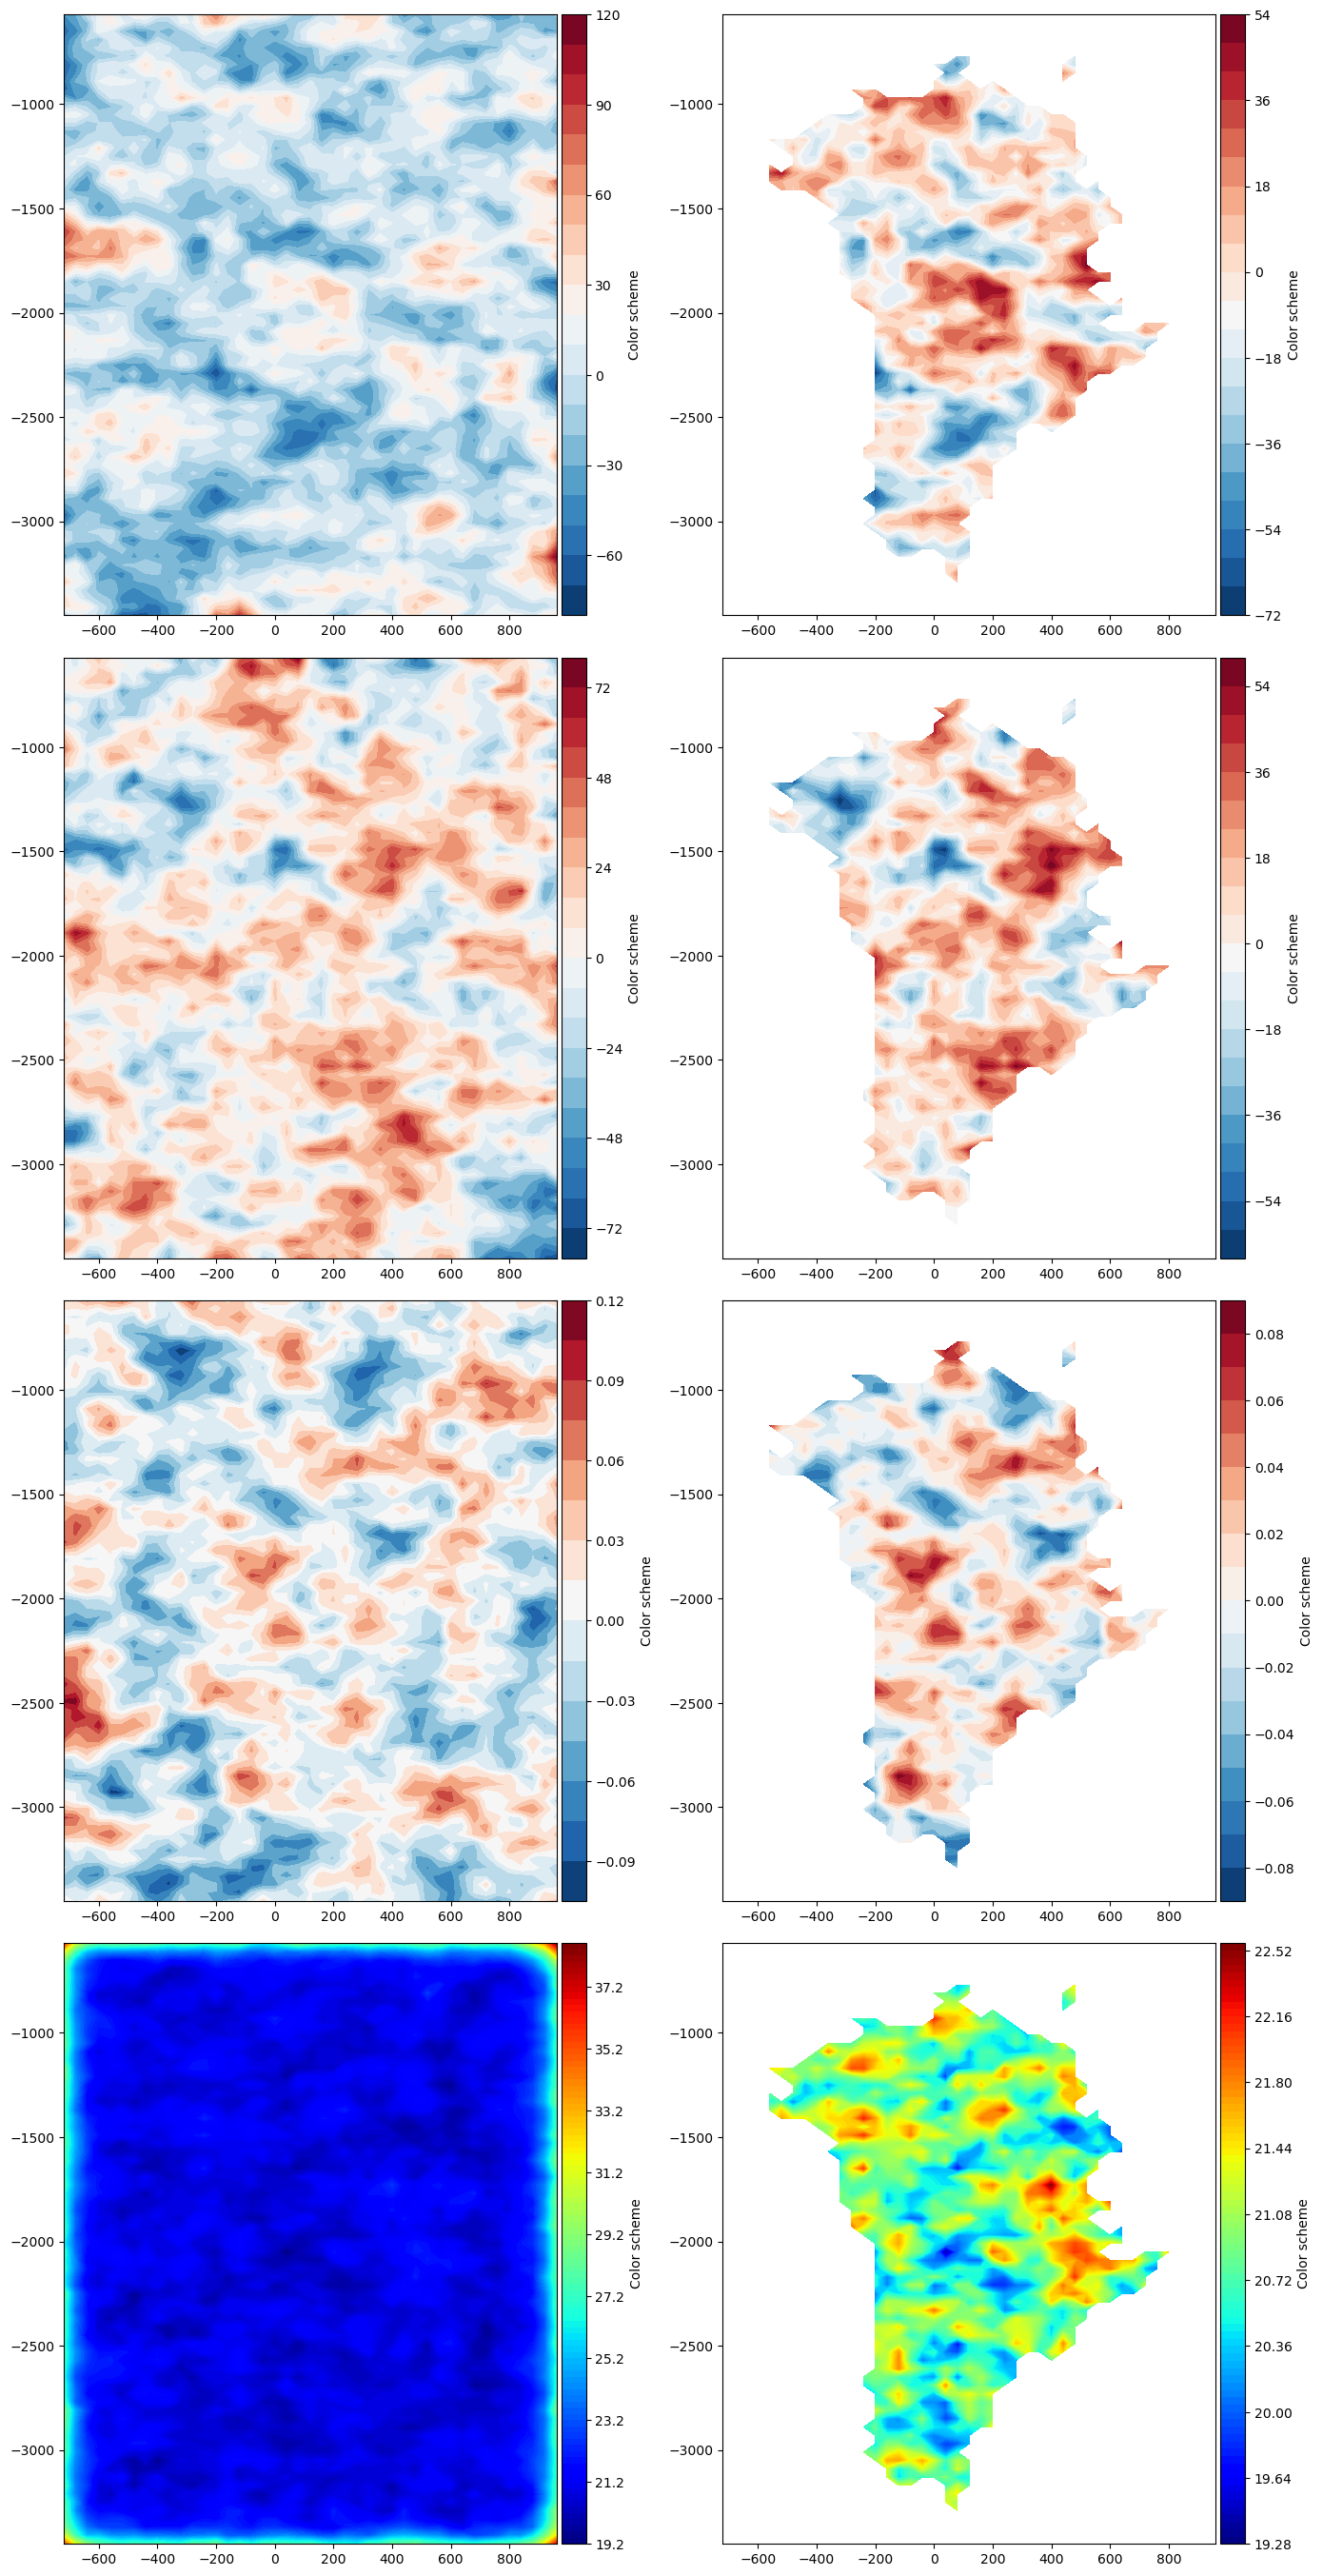

In [6]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_prior_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini", 1000, None)

ds_prior_X = DA.ds_prior_X.copy()

ds_subset_sample_prior_C_1 = DA.sample_prior_C()
ds_subset_sample_prior_C_2 = DA.sample_prior_C()
ds_mean_samples_prior_C, ds_std_samples_prior_C = DA.ds_prior_C_mean, DA.ds_prior_C_std

ds_subset_sample_prior_1 = DA.sample_prior()
ds_subset_sample_prior_2 = DA.sample_prior()
ds_mean_samples_prior, ds_std_samples_prior = DA.pointwise_marginals("prior", 1000)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_1["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_2["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior_C["xx_c_slide_initd"].data/ds_std_samples_prior_C["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior_C["xx_c_slide_initd"].data/ds_std_samples_prior_C["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior_C["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior_C["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

In [ ]:
H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (16,24)
n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

In [ ]:
ds_x = DA.create_ad_tlm_action_input_nc(bool_randomize = True)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

In [ ]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

In [ ]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")
ds_A_SigmaXCx = DA.eval_tlm_action()
ds_noise_cov_inv_A_SigmaXCx = DA.eval_noise_cov_inv_action(ds_A_SigmaXCx)

dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)

ds_CT_XT_SigmaT_H_misfit_SigmaXCx = DA.eval_prior_preconditioned_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]), DA.l2_inner_product([ds_A_SigmaXCx, ds_noise_cov_inv_A_SigmaXCx], ["tlmhessaction", "adjhessaction"])

In [ ]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")
ds_SigmaXC_inv_SigmaXCx = DA.eval_sqrt_prior_cov_inv_action()

DA.l2_inner_product([ds_SigmaXC_inv_SigmaXCx, ds_SigmaXC_inv_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"])

In [ ]:
DA.l2_inner_product([ds_SigmaXCx, ds_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"])

In [ ]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()

ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")

ds_SigmaXCx_as_adj_fields = xr.open_dataset(DA.dict_ad_inp_nc_files["tlm_action"])
ds_SigmaXCx_as_adj_fields = ds_SigmaXCx_as_adj_fields.rename({field + "d": field + "b" for field in dict_og_params_fields_vals})
for var in ds_SigmaXCx_as_adj_fields:
    if ds_SigmaXCx_as_adj_fields[var].attrs["type"] == "tlm":
        ds_SigmaXCx_as_adj_fields[var].attrs["type"] = "adj"
        if dict_params_fields_or_scalars[var[:-1]] == "scalar" and dict_params_fields_num_dims[var[:-1]] == "2D":
            ds_SigmaXCx_as_adj_fields[var].data[:, :] = ds_SigmaXCx_as_adj_fields[var].data.flat[0]/((IMAX+1)*(JMAX+1))
        elif dict_params_fields_or_scalars[var[:-1]] == "scalar" and dict_params_fields_num_dims[var[:-1]] == "3D":
            ds_SigmaXCx_as_adj_fields[var].data[:, :] = ds_SigmaXCx_as_adj_fields[var].data.flat[0]/((IMAX+1)*(JMAX+1)*(KCMAX+1))
        elif dict_params_fields_or_scalars[var[:-1]] == "scalar" and dict_params_fields_num_dims[var[:-1]] == "3DR":
            ds_SigmaXCx_as_adj_fields[var].data[:, :] = ds_SigmaXCx_as_adj_fields[var].data.flat[0]/((IMAX+1)*(JMAX+1)*(KRMAX+1))
ds_SigmaXCx_as_adj_fields.to_netcdf(DA.dict_ad_out_nc_files["adj_action"])

ds_CT_XT_SigmaT_SigmaXCx = DA.eval_sqrt_prior_covT_action(ad_key_adj_or_adj_action = "adj_action")

DA.l2_inner_product([ds_SigmaXCx, ds_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_SigmaXCx], ["tlm", "adj"])

In [ ]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_CT_XT_SigmaT_H_SigmaXCx = DA.eval_prior_preconditioned_hessian_action()

DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]), \
DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]) + DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"]), \
DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_SigmaXCx], ["tlm", "adj"])

In [ ]:
# DA = optim.DataAssimilation(sicopolis_dir, simulation,
#                             dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
#                             dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
#                             dict_og_params_fields_vals, dict_prior_params_fields_vals, dict_params_fields_num_dims, 
#                             dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
#                             dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
#                             MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini", None, ds_prior_X)

# ds = DA.gradient_descent(2, init_alpha = 1.0, min_alpha_tol = 1.e-10)

# H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
# H_data = H_data_40["H"].data
# mask = 1.0*(H_data > 0)
# mask[mask == 0] = np.nan

# n_rows, n_cols = 2, 2
# aspect_ratio = len(xModel40)/len(yModel40)
# subplot_width = 4
# subplot_height = subplot_width / aspect_ratio
# plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
# fig, ax = plt.subplots(n_rows, n_cols)

# fancyPlotter.plot_normal(xModel40, 
#                          yModel40, 
#                          ds["xx_c_slide_init"].data,
#                          cmap = 'RdBu_r', nbins = 20, vmin = -1, vmax = 1, fig = fig, ax = ax[0, 0])
# fancyPlotter.plot_normal(xModel40, 
#                          yModel40, 
#                          ds["xx_c_slide_init"].data*mask,
#                          cmap = 'RdBu_r', nbins = 20, vmin = -1, vmax = 1, fig = fig, ax = ax[0, 1])
# fancyPlotter.plot_normal(xModel40, 
#                          yModel40, 
#                          10**ds["xx_c_slide_init"].data,
#                          cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 0])
# fancyPlotter.plot_normal(xModel40, 
#                          yModel40, 
#                          10**ds["xx_c_slide_init"].data*mask,
#                          cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 1])
# plt.tight_layout()

In [ ]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_prior_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini", None, ds_prior_X)

ds = DA.inexact_gn_hessian_cg(MAX_ITERS = 5, min_alpha_cg_tol = 1.e-20, init_alpha_gd = 1.e-6, min_alpha_gd_tol = 1.e-20)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 3, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data,
                         cmap = 'RdBu_r', nbins = 20, vmin = -2, vmax = 2, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -2, vmax = 2, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data*mask,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_q_geo"].data,
                         cmap = 'RdBu_r', nbins = 20, vmin = -2, vmax = 2, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_q_geo"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -2, vmax = 2, fig = fig, ax = ax[2, 1])
plt.tight_layout()

In [ ]:
ds

In [16]:
temp = xr.open_dataset("/home/shreyas/update_to_develop_sicopolis/sicopolis_tuneCS_mini/src/subroutines/tapenade/ad_io/ad_output_adj.nc")
temp["xx_n_glen_da_dummy2d_scalar"].data[0], ds["xx_n_glen_da_dummy2d_scalar"].data[0]

(0.6444682687231819, 0.6444682687231822)

In [17]:
# start_dp = time.time()

# Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise")
# Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise", 
#                                                                                                               Omega = Omega_misfit_dp, Y = Y_misfit_dp, Q = Q_misfit_dp, MQ = MQ_misfit_dp)

# end_dp = time.time()
# print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
# start_sa = time.time()

# Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(20, 5, mode = "misfit_prior_precond", str_pass = "single_approx")
# Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(20, 5, mode = "misfit_prior_precond", str_pass = "single_approx", 
#                                                                                                               Omega = Omega_misfit_sa, Y = Y_misfit_sa, Q = Q_misfit_sa, MQ = MQ_misfit_sa)

# end_sa = time.time()
# print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

# plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
# plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
# plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
# plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

# plt.axhline(1, color = "green")

# np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

In [18]:
# start_dp = time.time()

# Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise")
# Omega_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini/REVD_double_precise/Omega_misfit.npy")
# Y_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini/REVD_double_precise/Y_misfit.npy")
# Q_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini/REVD_double_precise/Q_misfit.npy")
# MQ_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini/REVD_double_precise/MQ_misfit.npy")
# Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise", 
#                                                                                                               Omega = Omega_misfit_dp, Y = Y_misfit_dp, Q = Q_misfit_dp, MQ = MQ_misfit_dp)

# end_dp = time.time()
# print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
# start_sa = time.time()

# Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(20, 5, mode = "misfit_prior_precond", str_pass = "single_approx")
# Omega_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini/REVD_single_approx/Omega_misfit.npy")
# Y_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini/REVD_single_approx/Y_misfit.npy")
# Q_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini/REVD_single_approx/Q_misfit.npy")
# MQ_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini/REVD_single_approx/MQ_misfit.npy")
# Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(20, 5, mode = "misfit_prior_precond", str_pass = "single_approx", 
#                                                                                                               Omega = Omega_misfit_sa, Y = Y_misfit_sa, Q = Q_misfit_sa, MQ = MQ_misfit_sa)

# end_sa = time.time()
# print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

# plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
# plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
# plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
# plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

# plt.axhline(1, color = "green")

# np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

Relative symmetry error of T:  3.0004488170741845e-13
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  1.4891951669118514e-15
eig (symmetrized) vs eigh:  1.854040776051298e-15
First 10 eigenvalues: [3.23682696 2.15182718 1.77070094 1.65061366 1.25481358 1.10973868
 0.88654014 0.75852598 0.65502393 0.61226781]
Relative symmetry error of T:  5.673127191151346e-13
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  9.54144830665993e-16
eig (symmetrized) vs eigh:  2.117687268201724e-15
First 13 eigenvalues: [3.24769577 2.1841086  2.00503735 1.70398974 1.26136232 1.14045962
 0.91883682 0.75937755 0.69991224 0.69138835 0.6012596  0.52945431
 0.47011374]
Double precise total time: 313.2918 seconds


/home/shreyas/pySICOPOLIS/src/pySICOPOLIS/optim/optim.py:1633: RuntimeWarning: revd: Check the comments at the start of this function to see what might be missing from the single pass, it's essentially remark 5.4 of Halko, Martinsson, Tropp's paper.
  warnings.warn("revd: Check the comments at the start of this function to see what might be missing from the single pass, it's essentially remark 5.4 of Halko, Martinsson, Tropp's paper.", RuntimeWarning)


Condition number of Q.T @ Omega:  2.928204315678605
Minimum singular value of Q.T @ Omega:  4.14164213999878
Condition number of Q.T @ Omega explicitly computed:  2.9282043156786064
Relative symmetry error of T:  4.177775074585853e-13
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  2.329108272228263e-15
eig (symmetrized) vs eigh:  1.2044436655277178e-15
First 10 eigenvalues: [2.33402412 1.72223064 1.30455209 1.06264413 0.76692867 0.6205218
 0.53458658 0.50870049 0.39540455 0.3731127 ]
Condition number of Q.T @ Omega:  2.9920097380144575
Minimum singular value of Q.T @ Omega:  4.267473701347294
Condition number of Q.T @ Omega explicitly computed:  2.9920097380144566
Relative symmetry error of T:  4.296367802127434e-13
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  1.388539850551303e-15
eig (symmetrize

(array([3.24769577, 2.1841086 , 2.00503735, 1.70398974, 1.26136232,
        1.14045962, 0.91883682, 0.75937755, 0.69991224, 0.69138835,
        0.6012596 , 0.52945431, 0.47011374]),
 array([2.53907502, 1.81585824, 1.60785406, 1.14995063, 0.82924405,
        0.69968317, 0.60756324, 0.52812211, 0.47803993, 0.41058711,
        0.37307235, 0.34274262, 0.26803988]))

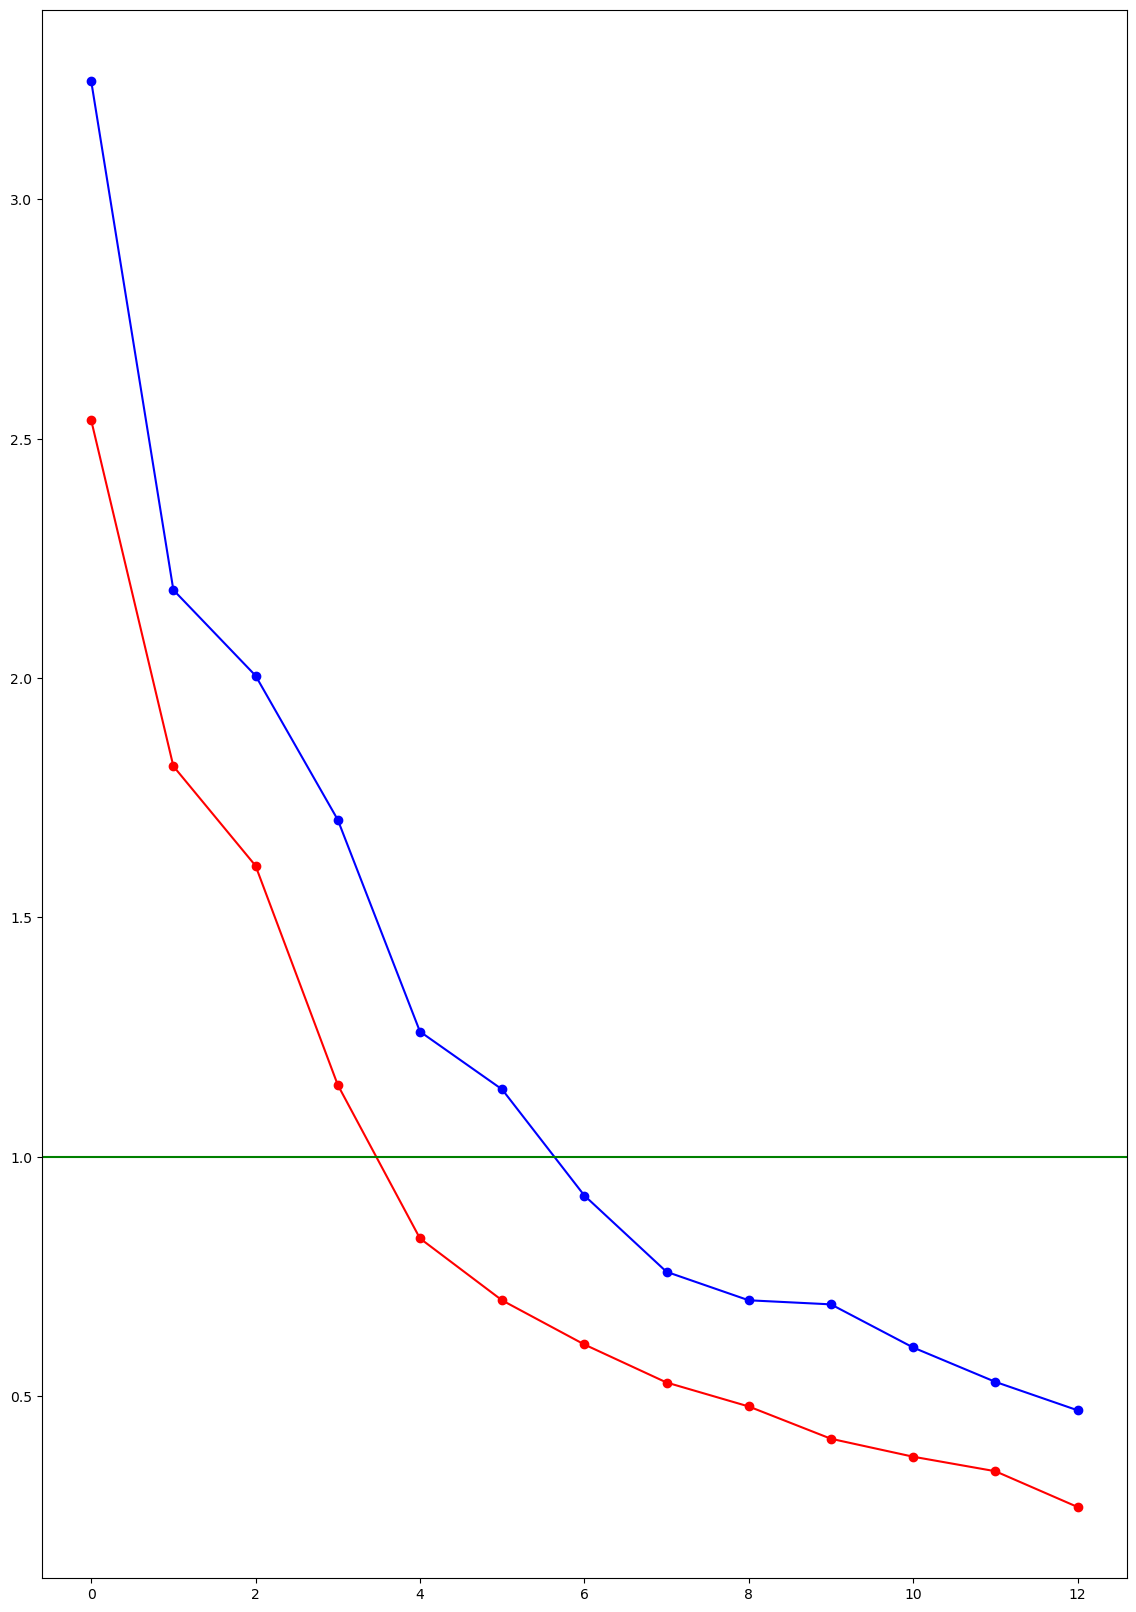

In [19]:
start_dp = time.time()
Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(13, 5, mode = "misfit_prior_precond", str_pass = "double_precise")

end_dp = time.time()
print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
start_sa = time.time()

Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(13, 5, mode = "misfit_prior_precond", str_pass = "single_approx")

end_sa = time.time()
print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

plt.axhline(1, color = "green")

np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

Relative symmetry error of T:  5.768568328080968e-13
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  1.643903066101586e-15
eig (symmetrized) vs eigh:  1.8523678548337272e-15
First 10 eigenvalues: [3.23674935 2.16944729 2.03831317 1.62696595 1.16411459 1.06515816
 0.80863535 0.75676156 0.68779893 0.60988381]
Relative symmetry error of T:  9.507015637745818e-13
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  2.8298477632669487e-15
eig (symmetrized) vs eigh:  1.8382555605602565e-15
First 20 eigenvalues: [3.26999069 2.20845999 2.10648127 1.73933615 1.26227525 1.18200752
 0.94281135 0.88163439 0.78428526 0.74838708 0.69532534 0.60443431
 0.51945446 0.48291575 0.432955   0.39156485 0.3351566  0.3108918
 0.26318239 0.25451607]
Relative symmetry error of T:  1.1376705677303362e-12
Complex parts check (imag > 

(array([3.30320073, 2.24003308, 2.15452933, 1.79667599, 1.32254181,
        1.25989265, 1.0050045 , 0.91578447, 0.85086003, 0.81796602,
        0.77583409, 0.7069883 , 0.60613174, 0.57745218, 0.56351696,
        0.52657572, 0.48302738, 0.39073536, 0.38316674, 0.35931748,
        0.35055014, 0.31894048, 0.30456341, 0.28004409, 0.27348738,
        0.25611759, 0.23358797, 0.22427916, 0.21954949, 0.21631908,
        0.20931595, 0.19832328, 0.18786331, 0.17900727, 0.17277166,
        0.16245202, 0.15539136, 0.1385072 , 0.13350615, 0.12791501,
        0.12030283, 0.11827908, 0.11117566, 0.10054573, 0.09940944,
        0.09570626, 0.09490588, 0.08903988, 0.08669024, 0.0834535 ]),
 array([3.05545003, 2.10028015, 1.92983426, 1.59783868, 1.17660935,
        1.12586757, 0.86530471, 0.7729094 , 0.70458788, 0.66781088,
        0.64244015, 0.61384484, 0.49776021, 0.46967783, 0.44995738,
        0.41919154, 0.3898349 , 0.31874014, 0.27643393, 0.26788147,
        0.26220877, 0.24193567, 0.21899815, 0.

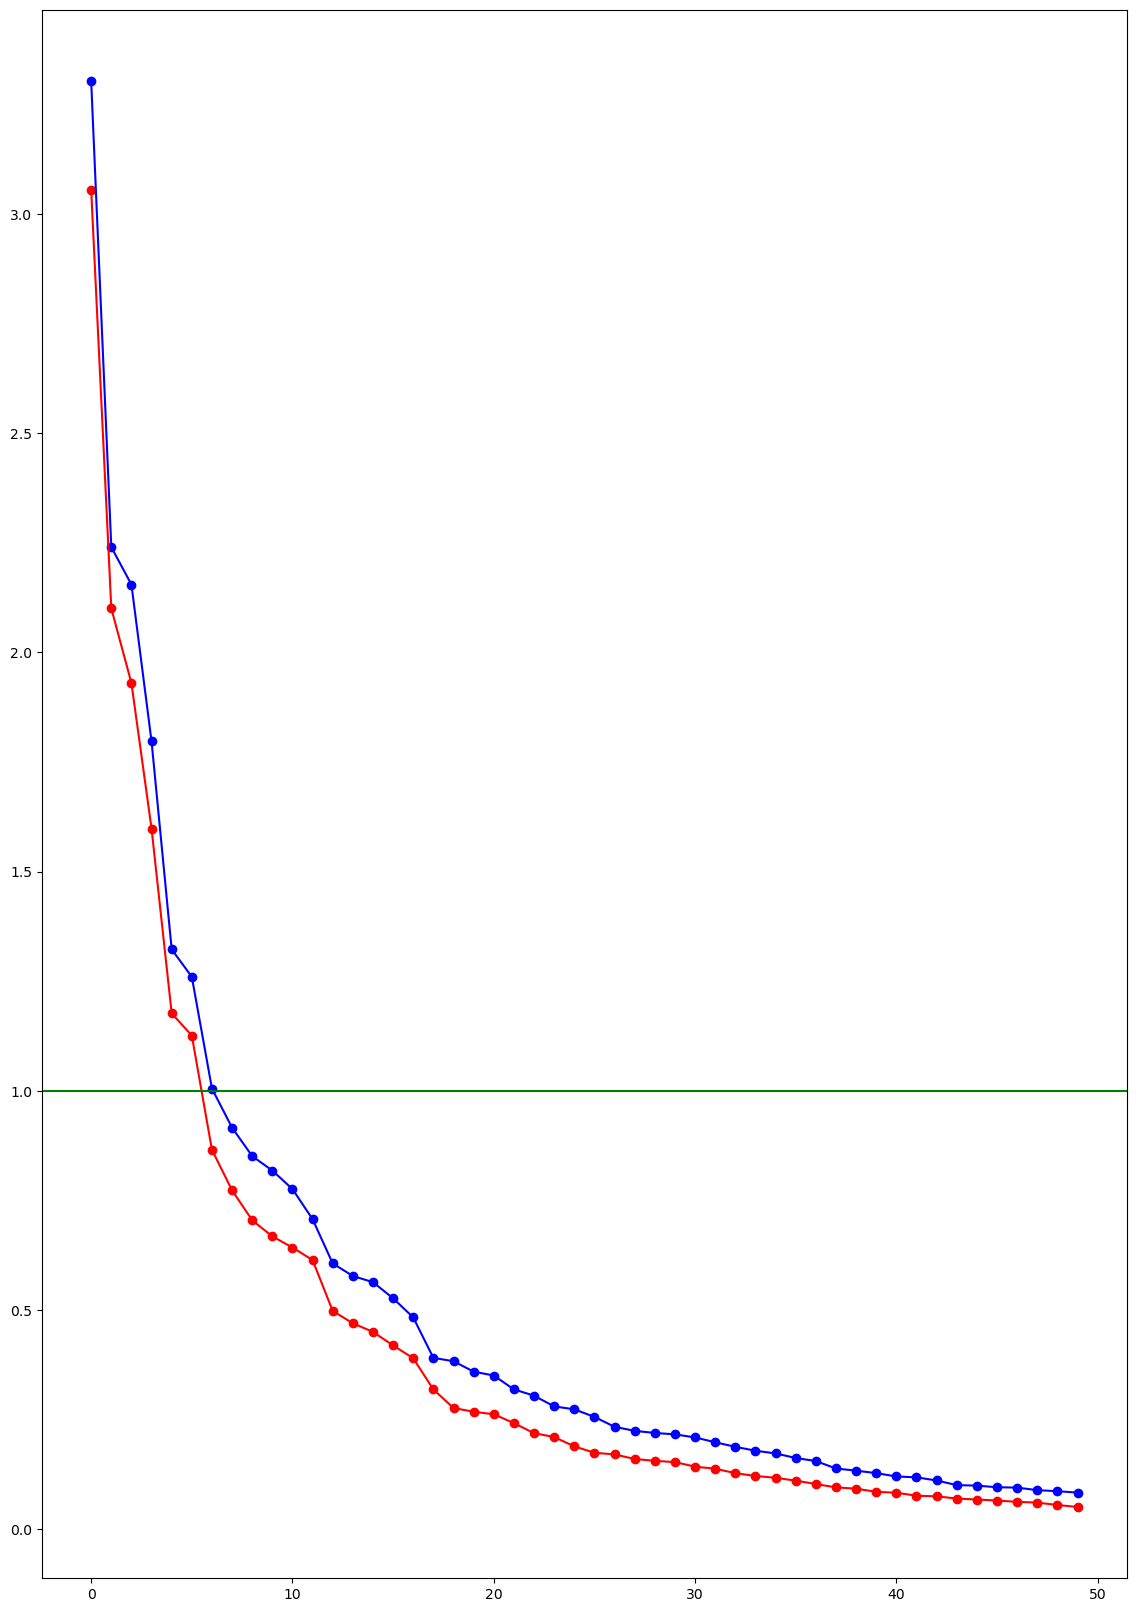

In [20]:
start_dp = time.time()
Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(50, 5, mode = "misfit_prior_precond", str_pass = "double_precise")

end_dp = time.time()
print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
start_sa = time.time()

Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(50, 5, mode = "misfit_prior_precond", str_pass = "single_approx")

end_sa = time.time()
print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

plt.axhline(1, color = "green")

np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

In [21]:
# ds_state = xr.open_dataset("/scratch2/shreyas/tuneCS_mini/inexact_gn_hessian_cg/state_GNHessCG_iter_5.nc")
# ds_prior_X = xr.open_dataset("/scratch2/shreyas/tuneCS_mini/prior_X.nc")

# dict_og_params_fields_vals = {"xx_c_slide_init": ds_state["xx_c_slide_init"].data.copy(),
#                               "xx_q_geo": ds_state["xx_q_geo"].data.copy(),
#                               "xx_p_weert": ds_state["xx_p_weert"].data[0].copy(),
#                               "xx_q_weert": ds_state["xx_q_weert"].data[0].copy(),
#                               "xx_enh_fact_da_dummy2d_scalar": ds_state["xx_enh_fact_da_dummy2d_scalar"].data[0].copy(),
#                               "xx_enh_intg_da_dummy2d_scalar": ds_state["xx_enh_intg_da_dummy2d_scalar"].data[0].copy(),
#                               "xx_n_glen_da_dummy2d_scalar": ds_state["xx_n_glen_da_dummy2d_scalar"].data[0].copy()}

# DA = optim.DataAssimilation(sicopolis_dir, simulation,
#                             dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
#                             dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
#                             dict_og_params_fields_vals, dict_prior_params_fields_vals, dict_params_fields_num_dims, 
#                             dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
#                             dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
#                             MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini", None, ds_prior_X)

# start_dp = time.time()

# Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise")
# Omega_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini/REVD_double_precise/Omega_misfit.npy")
# Y_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini/REVD_double_precise/Y_misfit.npy")
# Q_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini/REVD_double_precise/Q_misfit.npy")
# MQ_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini/REVD_double_precise/MQ_misfit.npy")
# Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise", 
#                                                                                                               Omega = Omega_misfit_dp, Y = Y_misfit_dp, Q = Q_misfit_dp, MQ = MQ_misfit_dp)

# end_dp = time.time()
# print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
# start_sa = time.time()

# Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(20, 5, mode = "misfit_prior_precond", str_pass = "single_approx")
# Omega_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini/REVD_single_approx/Omega_misfit.npy")
# Y_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini/REVD_single_approx/Y_misfit.npy")
# Q_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini/REVD_single_approx/Q_misfit.npy")
# MQ_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini/REVD_single_approx/MQ_misfit.npy")
# Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(20, 5, mode = "misfit_prior_precond", str_pass = "single_approx", 
#                                                                                                               Omega = Omega_misfit_sa, Y = Y_misfit_sa, Q = Q_misfit_sa, MQ = MQ_misfit_sa)

# end_sa = time.time()
# print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

# plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
# plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
# plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
# plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

# plt.axhline(1, color = "green")

# np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

Relative symmetry error of T:  1.1965311713375432e-12
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  1.7404641278455898e-15
eig (symmetrized) vs eigh:  1.4922197494041336e-15
First 10 eigenvalues: [3.22631415 2.14741831 2.01073991 1.61339969 1.20780416 1.14803082
 0.91321873 0.8589593  0.77471539 0.72217219]
Relative symmetry error of T:  1.401056750858188e-12
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  1.5280409277408411e-15
eig (symmetrized) vs eigh:  1.2727735062168705e-15
First 20 eigenvalues: [3.26719532 2.21534787 2.09964073 1.73653203 1.29213325 1.23304925
 0.97674208 0.8799684  0.824391   0.77355613 0.71342417 0.65408441
 0.5564272  0.49834202 0.48769385 0.42263341 0.3632446  0.34634767
 0.31515845 0.30338602]
Relative symmetry error of T:  1.5442050883263326e-12
Complex parts check (imag

(array([3.30841686, 2.2471246 , 2.16140387, 1.80379166, 1.33466023,
        1.27116171, 1.02233363, 0.92381075, 0.87105331, 0.83018594,
        0.78761603, 0.72322601, 0.62820429, 0.60277069, 0.58732663,
        0.56061037, 0.51066897, 0.42266615, 0.40812278, 0.39286387,
        0.3769343 , 0.35978281, 0.34103192, 0.30752717, 0.30701986,
        0.29131229, 0.26072228, 0.25488397, 0.25104634, 0.24939681,
        0.24229287, 0.23816642, 0.23584556, 0.21989695, 0.2057663 ,
        0.19165749, 0.18791656, 0.18536337, 0.17852673, 0.16962892,
        0.16707477, 0.16387719, 0.14955738, 0.14662415, 0.14046042,
        0.13855497, 0.13186356, 0.12330873, 0.1181997 , 0.11747142,
        0.11673112, 0.11602008, 0.1136913 , 0.11134807, 0.10785564,
        0.10627285, 0.10282303, 0.1014083 , 0.09674733, 0.09454851,
        0.09294807, 0.09214551, 0.09081907, 0.09018489, 0.08924148,
        0.08844816, 0.08590312, 0.08464372, 0.08047782, 0.08012716,
        0.07727811, 0.0764422 , 0.07554922, 0.07

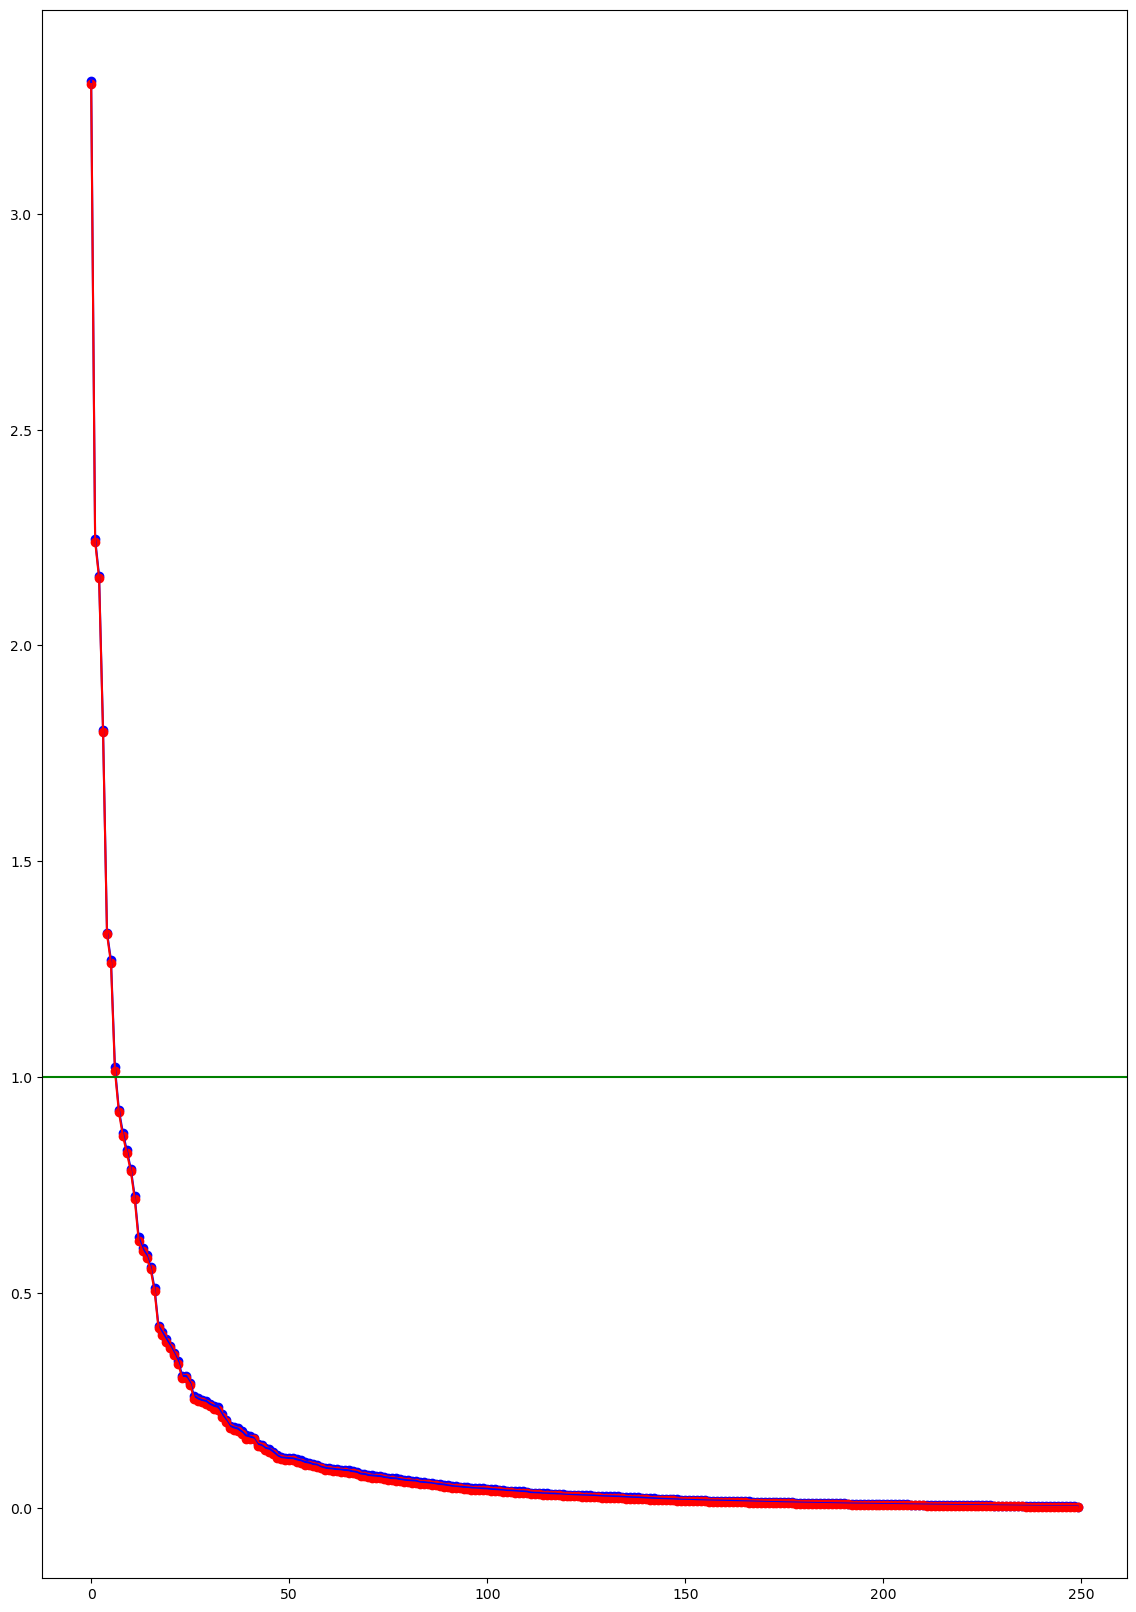

In [22]:
start_dp = time.time()
Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(250, 10, mode = "misfit_prior_precond", str_pass = "double_precise")

end_dp = time.time()
print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
start_sa = time.time()

Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(250, 10, mode = "misfit_prior_precond", str_pass = "single_approx")

end_sa = time.time()
print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

plt.axhline(1, color = "green")

np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

In [23]:
# sigma_B_squared_dp, sigma_P_squared_dp, delta_sigma_qoi_squared_dp = DA.forward_uq_propagation(U_misfit_dp, Lambda_misfit_dp)
sigma_B_squared_sa, sigma_P_squared_sa, delta_sigma_qoi_squared_sa = DA.forward_uq_propagation(U_misfit_sa, Lambda_misfit_sa)

# sigma_B_squared_dp, sigma_P_squared_dp, delta_sigma_qoi_squared_dp, sigma_B_squared_sa, sigma_P_squared_sa, delta_sigma_qoi_squared_sa
sigma_B_squared_sa, sigma_P_squared_sa, delta_sigma_qoi_squared_sa

(8.368685356591776e+17, 3.4997483021533574e+17, 0.5818042914713355)

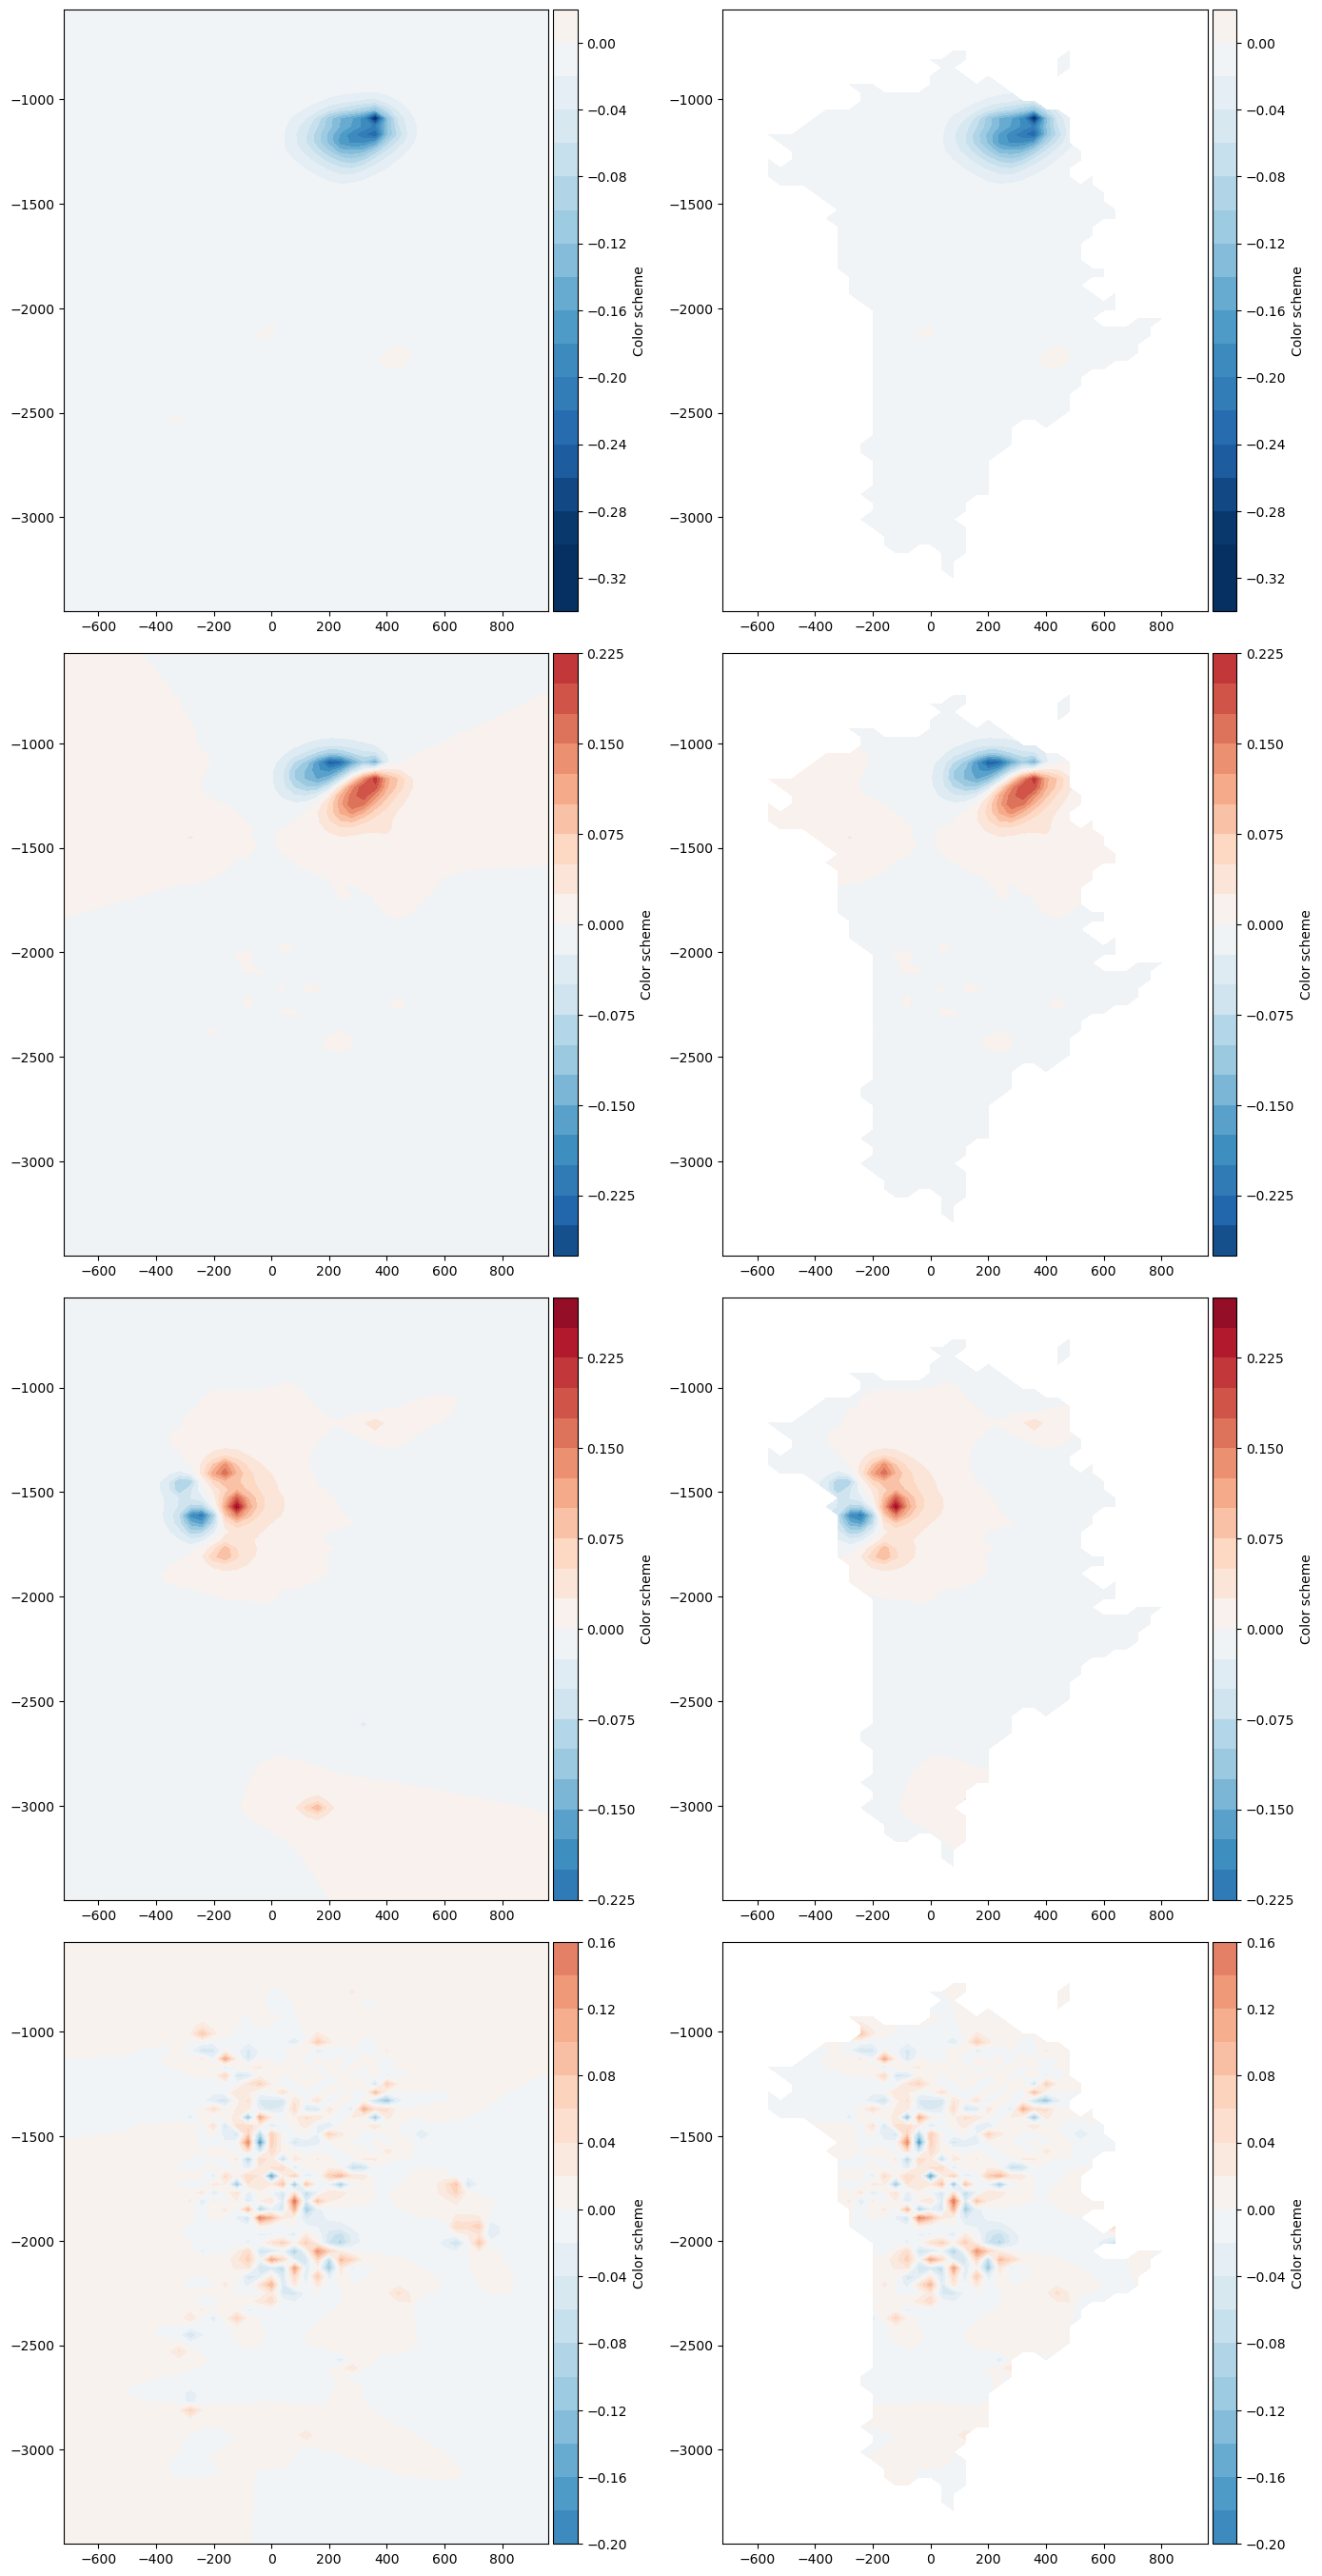

In [24]:
U_misfit_dp_reshaped = np.reshape(U_misfit_dp[:73*43, :], (73, 43, -1))

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 0],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 0]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 5],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 5]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 10],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 10]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, -1],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, -1]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 1])
plt.tight_layout()

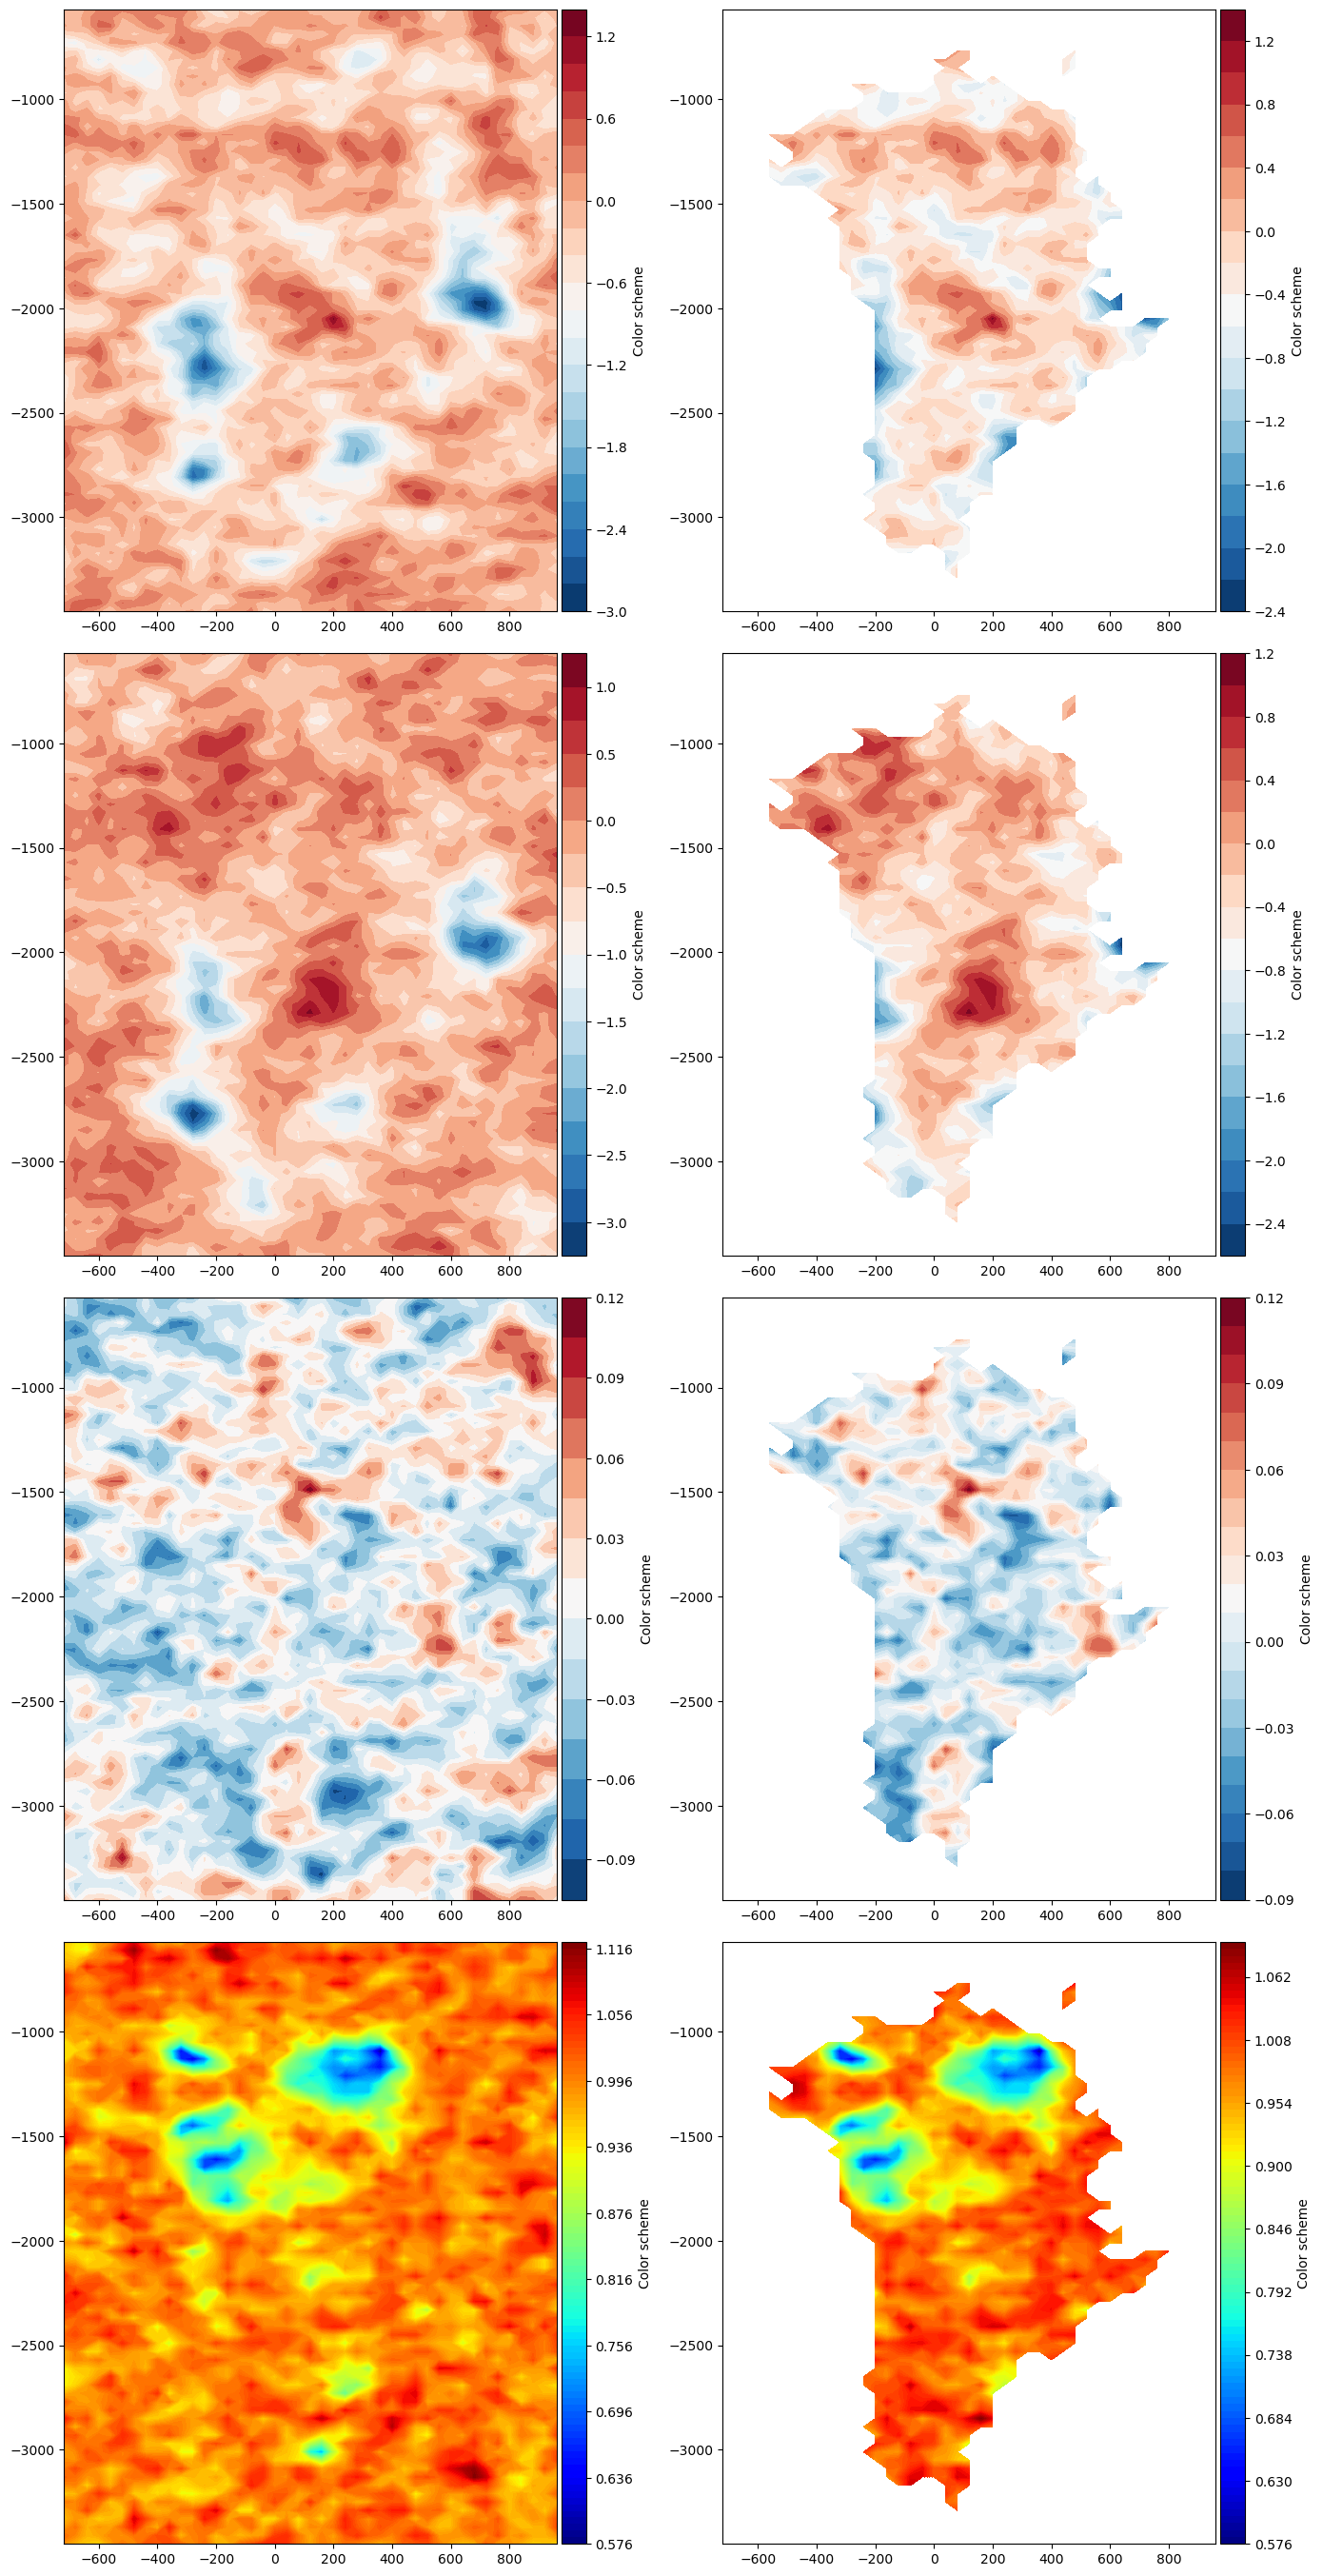

In [25]:
ds_subset_sample_posterior_1 = DA.sample_posterior(U_misfit_dp, Lambda_misfit_dp)
ds_subset_sample_posterior_2 = DA.sample_posterior(U_misfit_dp, Lambda_misfit_dp)
ds_mean_samples_posterior, ds_std_samples_posterior = DA.pointwise_marginals("posterior", 1000, U_misfit_dp, Lambda_misfit_dp)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

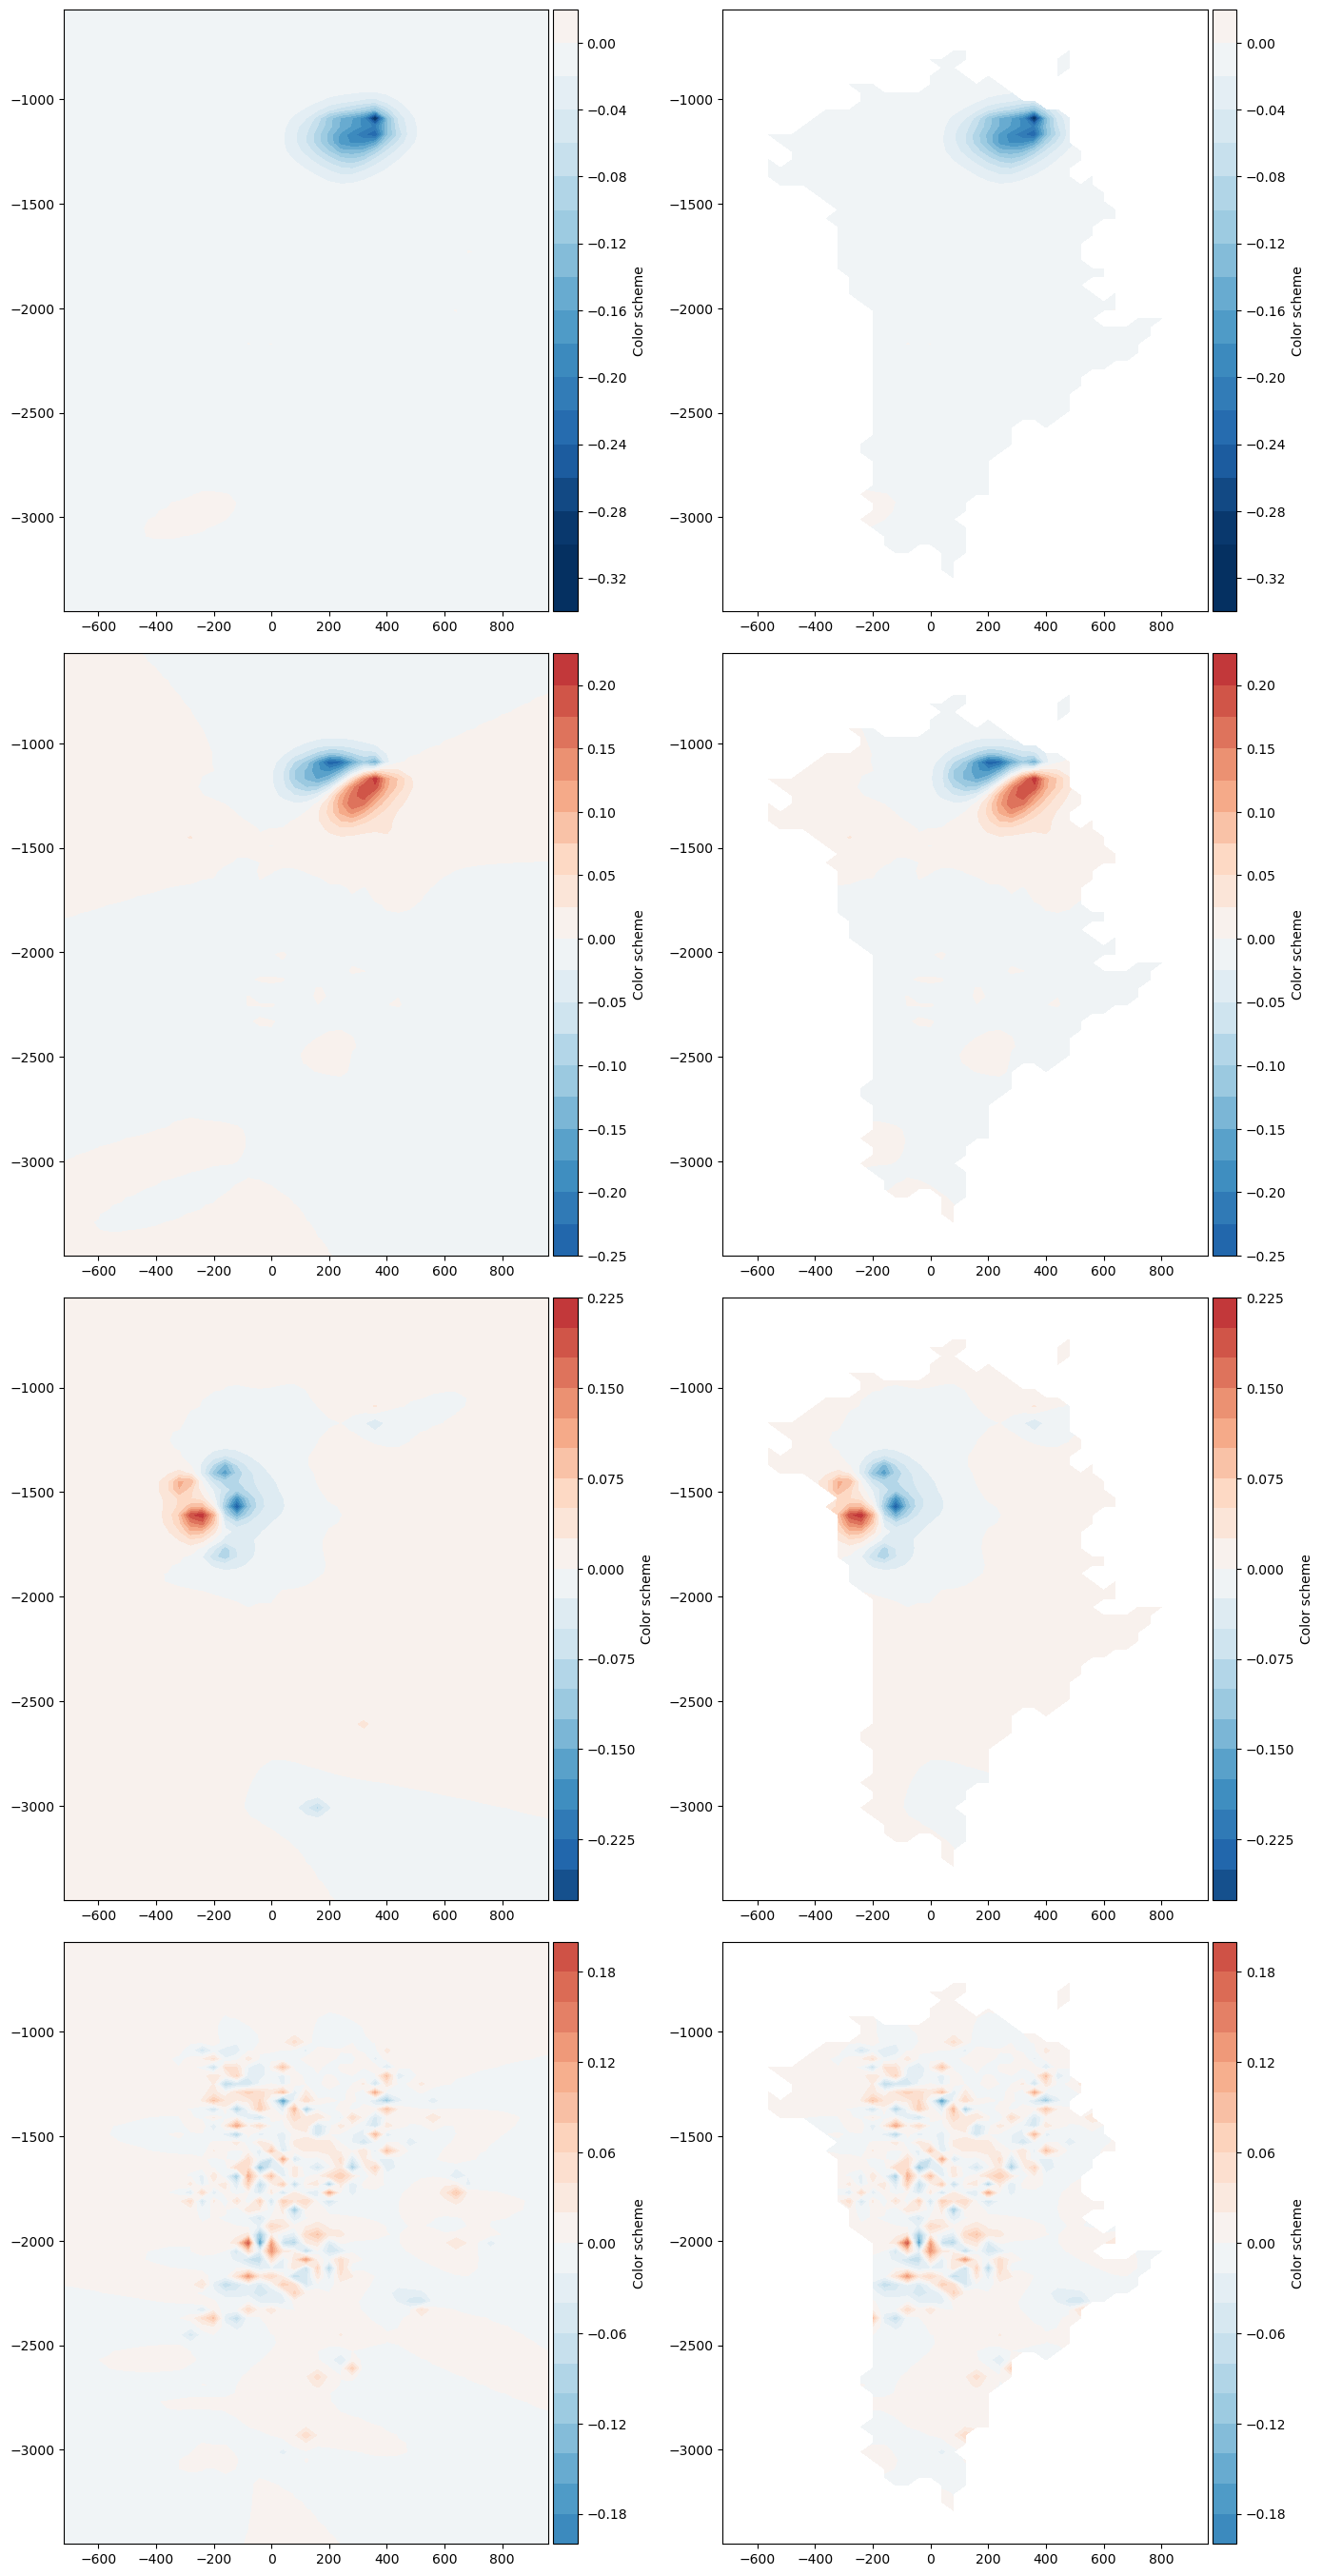

In [26]:
U_misfit_sa_reshaped = np.reshape(U_misfit_sa[:73*43, :], (73, 43, -1))

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 0],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 0]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 5],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 5]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 10],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 10]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, -1],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, -1]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 1])
plt.tight_layout()

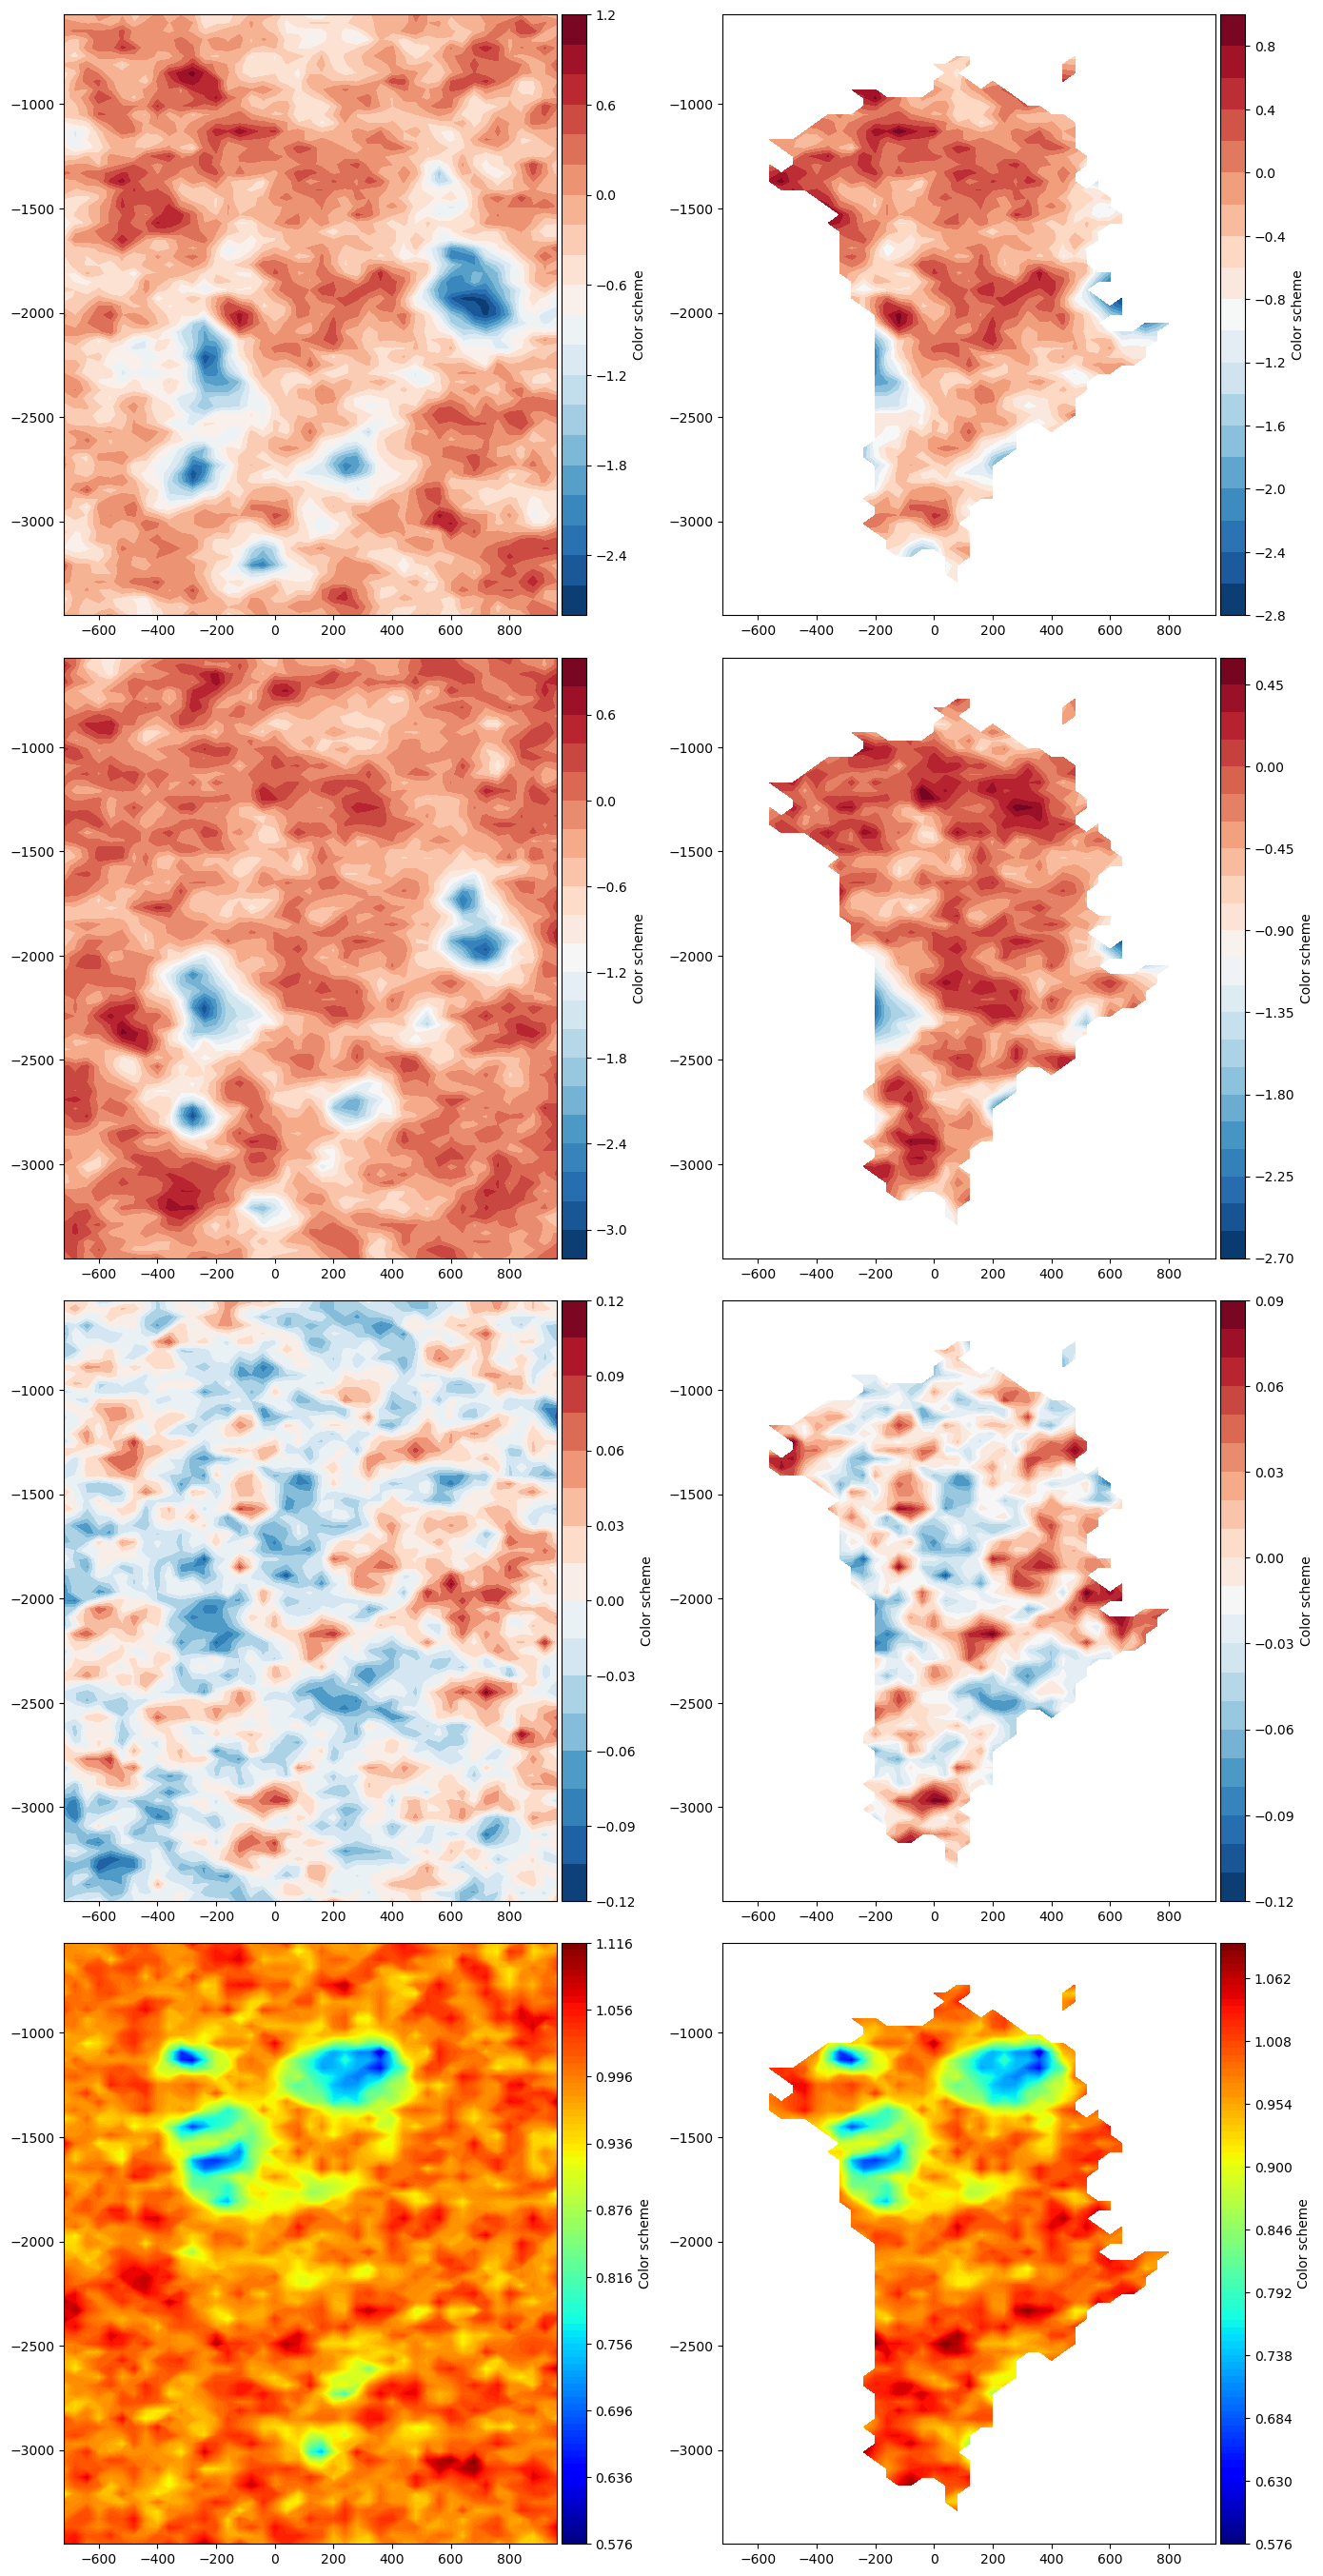

In [27]:
ds_subset_sample_posterior_1 = DA.sample_posterior(U_misfit_sa, Lambda_misfit_sa)
ds_subset_sample_posterior_2 = DA.sample_posterior(U_misfit_sa, Lambda_misfit_sa)
ds_mean_samples_posterior, ds_std_samples_posterior = DA.pointwise_marginals("posterior", 1000, U_misfit_sa, Lambda_misfit_sa)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

In [28]:
ds_std_samples_prior

<xarray.Dataset> Size: 51kB
Dimensions:                         (y: 73, x: 43, scalar: 1)
Coordinates:
  * y                               (y) float64 584B -3.45e+03 ... -570.0
  * x                               (x) float64 344B -720.0 -680.0 ... 960.0
Dimensions without coordinates: scalar
Data variables:
    xx_c_slide_initd                (y, x) float64 25kB 0.303 0.2929 ... 0.3049
    xx_q_geod                       (y, x) float64 25kB 0.2834 0.2982 ... 0.2916
    xx_p_weertd                     (scalar) float64 8B 0.009684
    xx_q_weertd                     (scalar) float64 8B 0.009483
    xx_enh_fact_da_dummy2d_scalard  (scalar) float64 8B 0.01011
    xx_enh_intg_da_dummy2d_scalard  (scalar) float64 8B 0.009908
    xx_n_glen_da_dummy2d_scalard    (scalar) float64 8B 0.01006

In [29]:
ds_std_samples_posterior

<xarray.Dataset> Size: 51kB
Dimensions:                         (y: 73, x: 43, scalar: 1)
Coordinates:
  * y                               (y) float64 584B -3.45e+03 ... -570.0
  * x                               (x) float64 344B -720.0 -680.0 ... 960.0
Dimensions without coordinates: scalar
Data variables:
    xx_c_slide_initd                (y, x) float64 25kB 0.3179 0.3109 ... 0.2935
    xx_q_geod                       (y, x) float64 25kB 0.2917 0.3007 ... 0.313
    xx_p_weertd                     (scalar) float64 8B 0.009452
    xx_q_weertd                     (scalar) float64 8B 0.00953
    xx_enh_fact_da_dummy2d_scalard  (scalar) float64 8B 0.007928
    xx_enh_intg_da_dummy2d_scalard  (scalar) float64 8B 0.009906
    xx_n_glen_da_dummy2d_scalard    (scalar) float64 8B 0.008571

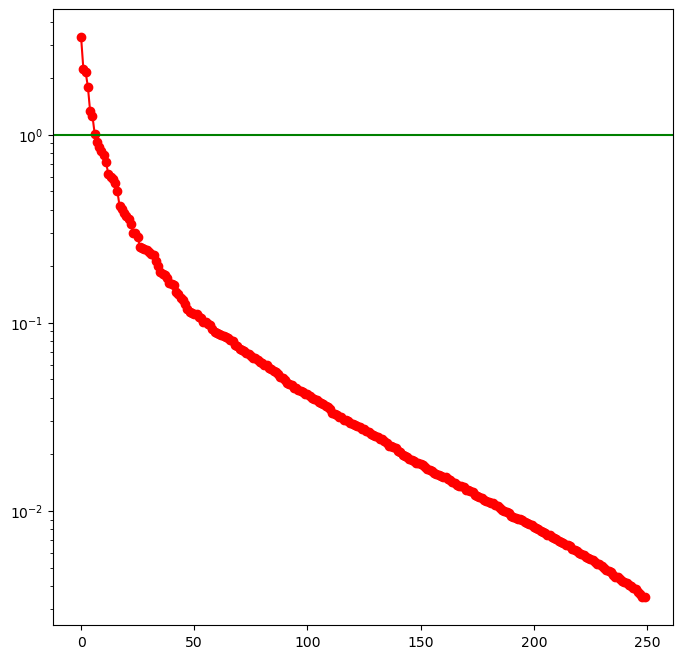

In [30]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color="red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color="red")

plt.axhline(1, color="green")

plt.yscale("log")

In [31]:
# DA = optim.DataAssimilation(sicopolis_dir, simulation,
#                             dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
#                             dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
#                             dict_og_params_fields_vals, dict_prior_params_fields_vals, dict_params_fields_num_dims, 
#                             dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
#                             dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
#                             MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini", None, ds_prior_X)

# DA.l_bfgs(5, 3)